In [47]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.2 gigabytes of available RAM

Not using a high-RAM runtime


In [48]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

root_dir = "/Users/trevorwiebe/Ktor/radar_backend/radar_data/"

data = pd.read_csv(root_dir + 'data/combined_data.csv')

In [49]:
def transform_dataframe(df, block_size):
    num_blocks = len(df) // block_size  # Number of complete blocks of block_size rows
    num_fields = block_size - 1  # Number of rows before the target row

    # Preallocate the dataframe for speed
    columns = (
        [f'dateTime_t', f'latitude_t', f'longitude_t', f'reflectivity_t'] +
        [item for i in range(1, num_fields + 1) for item in [f'dateTime_{i}', f'latitude_{i}', f'longitude_{i}', f'reflectivity_{i}']]
    )
    data = np.empty((num_blocks, len(columns)), dtype=object)  # Preallocate as object array

    # Convert DataFrame to numpy array for faster processing
    arr = df[['dateTime', 'latitude', 'longitude', 'reflectivity']].values

    # Process the blocks in bulk
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size

        # Use the last row in the block (target row)
        data[i, 0:4] = arr[end-1]  # Target row: dateTime_t, latitude_t, longitude_t, reflectivity_t

        # Use the first (block_size - 1) rows (1- (block_size - 1) rows)
        for j in range(num_fields):
            data[i, 4 + j*4] = arr[start+j, 0]  # dateTime_j+1
            data[i, 5 + j*4] = arr[start+j, 1]  # latitude_j+1
            data[i, 6 + j*4] = arr[start+j, 2]  # longitude_j+1
            data[i, 7 + j*4] = arr[start+j, 3]  # reflectivity_j+1

    # Create the final DataFrame
    transformed_df = pd.DataFrame(data, columns=columns)
    
    return transformed_df

df = transform_dataframe(data, 31)

In [50]:
# Setting device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [51]:
# Assuming 'df' is your original dataframe
reflectivity_columns = [f'reflectivity_{i}' for i in range(1, 31)]  # List of reflectivity columns

# Set reflectivity between -99.0 and -1.0 to 0 in both historical and target reflectivity columns
df[reflectivity_columns] = df[reflectivity_columns].map(lambda x: 0 if -99.0 <= x <= -1.0 else x)
df['reflectivity_t'] = df['reflectivity_t'].apply(lambda x: 0 if -99.0 <= x <= -1.0 else x)

# Define the number of timesteps (30) and features (latitude, longitude, minute)
timesteps = 30
features = 6  # latitude, longitude, minute, hour, month, reflectivity

# Create an array to hold the input sequences
X = np.zeros((len(df), timesteps, features))

# Convert the dateTime columns to datetime objects to extract the minute
for t in range(1, timesteps + 1):
    df[f'dateTime_{t}'] = pd.to_datetime(df[f'dateTime_{t}'])

# Loop through each timestep and fill in the features (latitude, longitude, minute)
for t in range(1, timesteps + 1):
    X[:, t - 1, 0] = df[f'latitude_{t}']   # latitude
    X[:, t - 1, 1] = df[f'longitude_{t}']  # longitude
    X[:, t - 1, 2] = df[f'dateTime_{t}'].dt.hour   # hour of the day
    X[:, t - 1, 3] = df[f'dateTime_{t}'].dt.minute  # minute of the hour
    X[:, t - 1, 4] = df[f'dateTime_{t}'].dt.month # month of the year
    X[:, t - 1, 5] = df[f'reflectivity_{t}'] 

# Target value: reflectivity_t (the value we want to predict)
y = df['reflectivity_t'].values

In [52]:
# Step 1: Reshape X from 3D to 2D
n_samples, n_timesteps, n_features = X.shape  # (675700, 30, 6)
X = X.reshape(-1, n_features)  # Reshape to (675700 * 30, 6)

# Step 2: Apply MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Scale each feature

# Step 3: Reshape back to the original 3D shape
X = X.reshape(n_samples, n_timesteps, n_features)

# For the target y, you can also scale it if needed:
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()  # Rescale y and flatten

In [53]:
# Create train, val and test splits

train_split = int(X.shape[0] * .8)
val_split = int(X.shape[0] * .9)

X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:val_split], y[train_split:val_split]
X_test, y_test = X[val_split:], y[val_split:]

X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

# # Use this if starting from scratch
# model1 = Sequential()
# model1.add(InputLayer((30, 6)))
# # LSTM layer with 64 units and dropout for regularization
# model1.add(LSTM(64, return_sequences=False))  # return_sequences=False because we predict one value
# model1.add(Dropout(0.2))  # Helps prevent overfitting

# # Dense layer for additional feature extraction
# model1.add(Dense(32, activation='relu'))  # Increased neurons for more complexity
# model1.add(Dropout(0.2))  # More dropout

# # Final output layer (predicting a single value)
# model1.add(Dense(1, activation='linear'))

# model1.summary()

In [55]:
model1 = load_model(root_dir + 'model/model5.keras')
cp = ModelCheckpoint(root_dir + 'model/model5.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [56]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, callbacks=[cp])
print("Finished training at " + datetime.now().strftime('%d/%m/%y %H:%M:%S.%f'))

Epoch 1/4
18452/18452 ━━━━━━━━━━━━━━━━━━━━ 105s 6ms/step - loss: 0.1353 - root_mean_squared_error: 0.3678 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118
Epoch 2/4
18452/18452 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - loss: 0.1347 - root_mean_squared_error: 0.3669 - val_loss: 0.1656 - val_root_mean_squared_error: 0.4070
Epoch 3/4
18452/18452 ━━━━━━━━━━━━━━━━━━━━ 104s 6ms/step - loss: 0.1331 - root_mean_squared_error: 0.3647 - val_loss: 0.1614 - val_root_mean_squared_error: 0.4017
Epoch 4/4
18452/18452 ━━━━━━━━━━━━━━━━━━━━ 103s 6ms/step - loss: 0.1294 - root_mean_squared_error: 0.3597 - val_loss: 0.1699 - val_root_mean_squared_error: 0.4122
Finished training at 22/09/24 21:47:01.731656


In [57]:
def make_predictions(X_pred, y_pred):
    test_predictions = model1.predict(X_pred).flatten()
    # third_column = np.flip(X_pred[:, :, X_pred.shape[2]-1], axis=1)
    third_column = X_pred[:, :, X_pred.shape[2]-1]
    X_test_strings = [' '.join(map(str, row)) for row in third_column]
    test_results = pd.DataFrame(data={'Historical':X_test_strings, 'Actuals':y_pred, 'Val Predictions':test_predictions,})
    # sorted_results = test_results.sort_values(by='Actuals', ascending=False)
    return test_results[:500]

In [58]:
X_test_predictions = make_predictions(X_test, y_test)

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


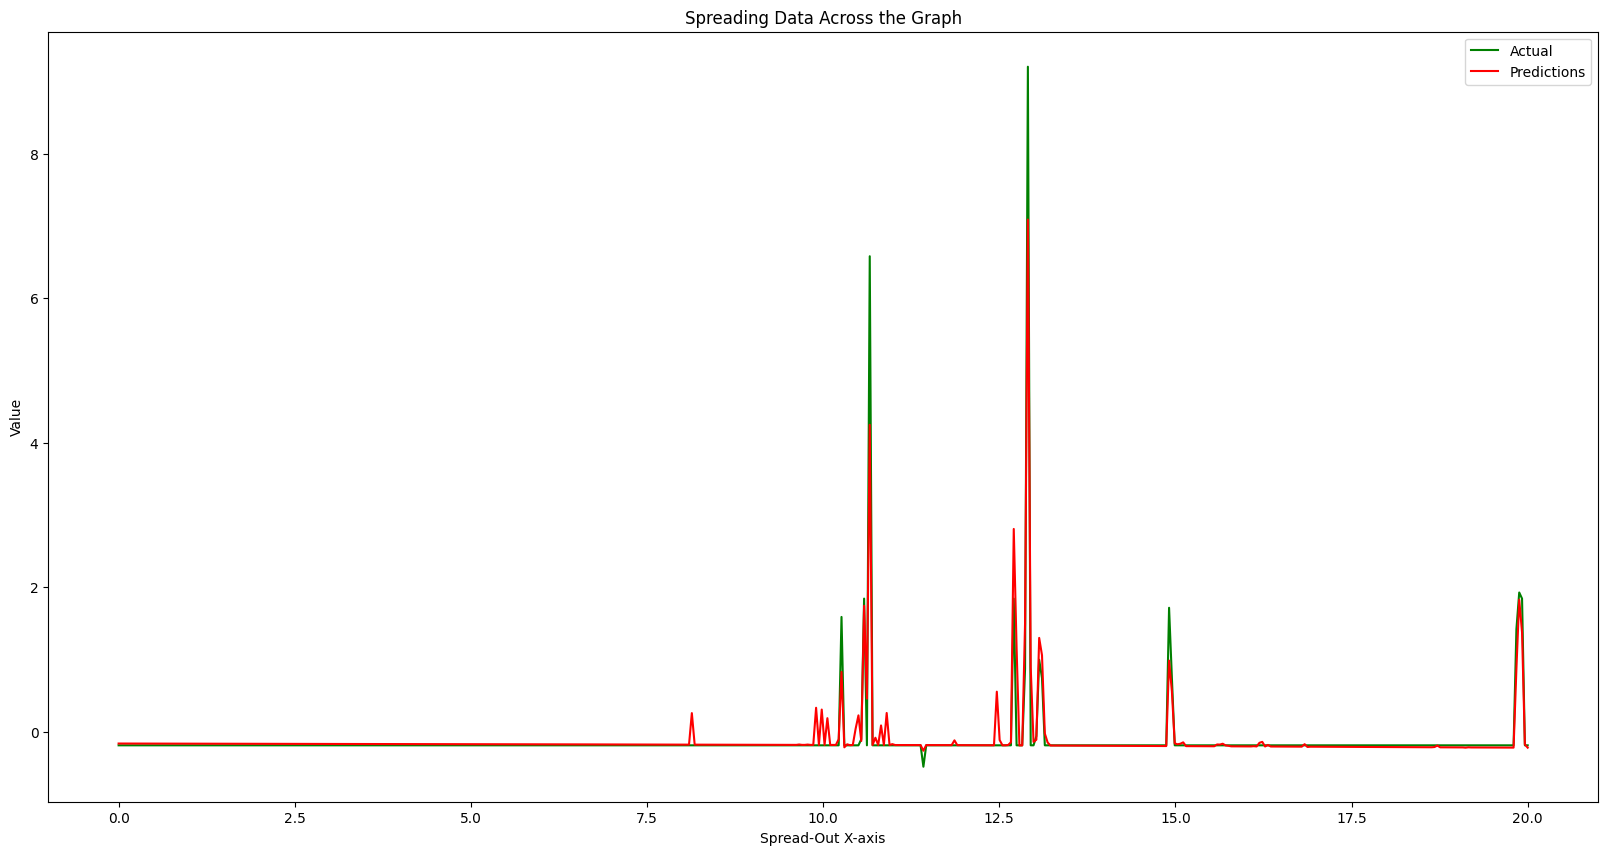

In [59]:
def plot_data(returned_data):
    actuals = returned_data['Actuals']
    predictions = returned_data['Val Predictions']

    x_positions = np.linspace(0, 20, len(predictions))  # Spread x data across the range 0 to 10
    y_positions = np.linspace(0, 20, len(actuals))  # Spread y data across the range 0 to 10

    # Plotting the line graph
    plt.plot(y_positions, actuals, label='Actual', color='green')   # Plot y with its new positions
    plt.plot(x_positions, predictions, label='Predictions', color='red')  # Plot x with its new positions

    plt.rcParams["figure.figsize"] = (20,10)

    # Adding labels, title, and legend
    plt.xlabel('Spread-Out X-axis')
    plt.ylabel('Value')
    plt.title('Spreading Data Across the Graph')
    plt.legend()  # Show the legend

    # Show the graph
    plt.show()

plot_data(X_test_predictions)

2307/2307 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


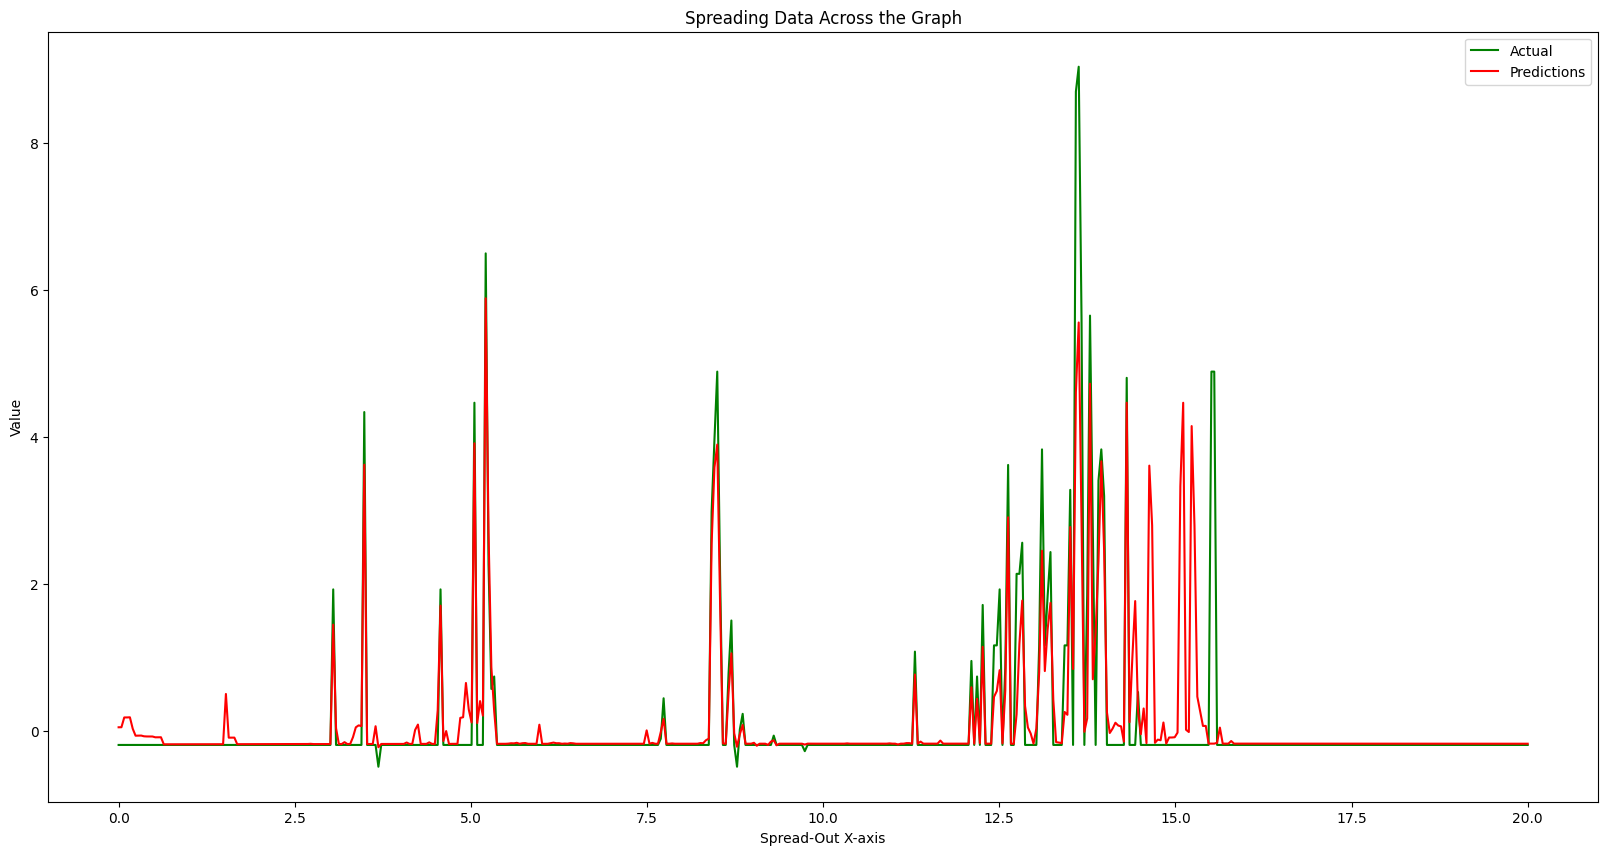

In [60]:
X_val_predictions = make_predictions(X_val, y_val)
plot_data(X_val_predictions)

18452/18452 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


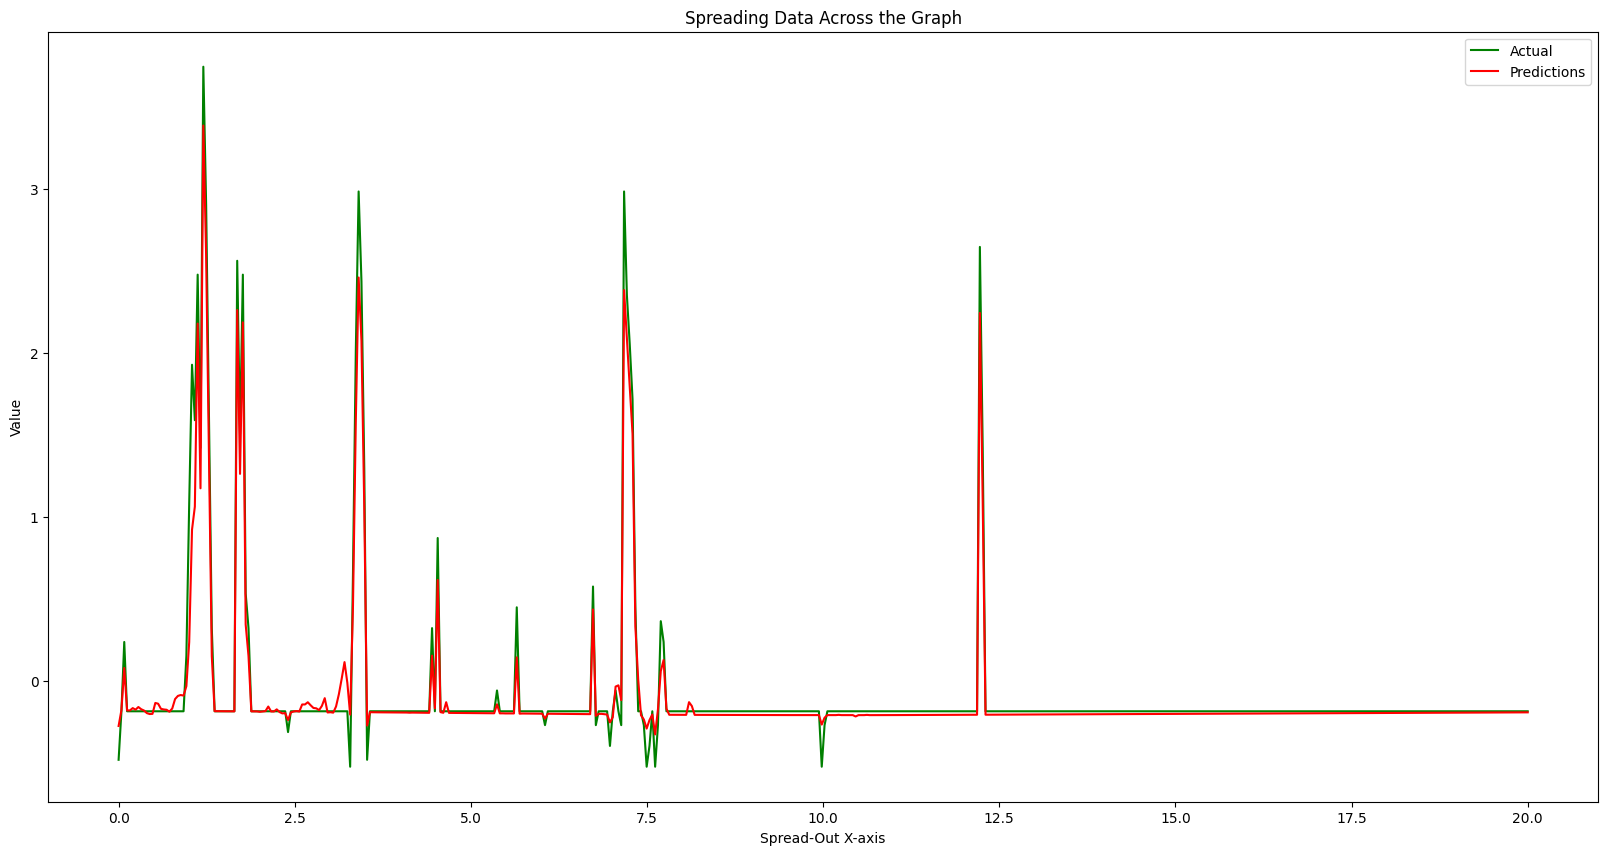

In [61]:
X_train_predictions = make_predictions(X_train, y_train)
plot_data(X_train_predictions)